# IMDB Movie Review Classification: One‑Hot Sequential RNN (`num_words=200`)

This notebook modifies the preprocessing so that **each input is a sequence of vectors** and the resulting `x_train` has shape **(25000, 500, 200)**:

- **25,000** training samples
- **500** time steps per review (reviews are padded/truncated to 500 tokens)
- **200** features per time step (one‑hot over the 200 most frequent words)

train a **recurrent network** (Bidirectional GRU by default), plot training/validation accuracy, pick the best epoch by validation accuracy, retrain on train+val, and report the final **test accuracy**.


In [1]:
# Setup
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

print(tf.__version__)

2.11.0


Load IMDB and prepare one‑hot sequential inputs

In [2]:
# Parameters
NUM_WORDS = 200       
SEQ_LEN   = 500       
VAL_SIZE  = 10000     
BATCH     = 256
EPOCHS    = 7     

# Load IMDB with vocabulary capped at 200 most frequent words
(x_train_ids, y_train), (x_test_ids, y_test) = keras.datasets.imdb.load_data(num_words=NUM_WORDS)

# Pad/truncate integer sequences to length SEQ_LEN
x_train_ids = keras.preprocessing.sequence.pad_sequences(x_train_ids, maxlen=SEQ_LEN, truncating='pre', padding='pre')
x_test_ids  = keras.preprocessing.sequence.pad_sequences(x_test_ids,  maxlen=SEQ_LEN, truncating='pre', padding='pre')

x_train = tf.one_hot(x_train_ids, depth=NUM_WORDS, dtype=tf.float32)  
x_test  = tf.one_hot(x_test_ids,  depth=NUM_WORDS, dtype=tf.float32) 

x_train.shape, x_test.shape, y_train.shape, y_test.shape

(TensorShape([25000, 500, 200]),
 TensorShape([25000, 500, 200]),
 (25000,),
 (25000,))

Train/Validation split (temporal order preserved)

In [3]:
# hold out the last VAL_SIZE samples of the original training set for validation
x_tr, x_val = x_train[:-VAL_SIZE], x_train[-VAL_SIZE:]
y_tr, y_val = y_train[:-VAL_SIZE], y_train[-VAL_SIZE:]

x_tr.shape, x_val.shape, y_tr.shape, y_val.shape

(TensorShape([15000, 500, 200]),
 TensorShape([10000, 500, 200]),
 (15000,),
 (10000,))

Build a recurrent model

In [4]:
def build_rnn_model():
    model = keras.Sequential([
        layers.Input(shape=(SEQ_LEN, NUM_WORDS)),
        # Regularization helps generalization with tiny vocab
        layers.Bidirectional(layers.GRU(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid'),
    ])
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_rnn_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 128)              102144    
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 110,465
Trainable params: 110,465
Non-trainable params: 0
_________________________________________________________________


Train with validation, plot accuracy, and pick best epoch

Epoch 1/7
59/59 [==============================] - 704s 12s/step - loss: 0.6907 - accuracy: 0.5294 - val_loss: 0.6853 - val_accuracy: 0.5497
Epoch 2/7
59/59 [==============================] - 828s 14s/step - loss: 0.6635 - accuracy: 0.6042 - val_loss: 0.6418 - val_accuracy: 0.6329
Epoch 3/7
59/59 [==============================] - 843s 14s/step - loss: 0.6059 - accuracy: 0.6730 - val_loss: 0.5484 - val_accuracy: 0.7268
Epoch 4/7
59/59 [==============================] - 804s 14s/step - loss: 0.5840 - accuracy: 0.6951 - val_loss: 0.5379 - val_accuracy: 0.7277
Epoch 5/7
59/59 [==============================] - 904s 15s/step - loss: 0.5483 - accuracy: 0.7285 - val_loss: 0.5041 - val_accuracy: 0.7595
Epoch 6/7
59/59 [==============================] - 878s 15s/step - loss: 0.5230 - accuracy: 0.7468 - val_loss: 0.5151 - val_accuracy: 0.7453
Epoch 7/7
59/59 [==============================] - 852s 14s/step - loss: 0.5181 - accuracy: 0.7492 - val_loss: 0.4970 - val_accuracy: 0.7597


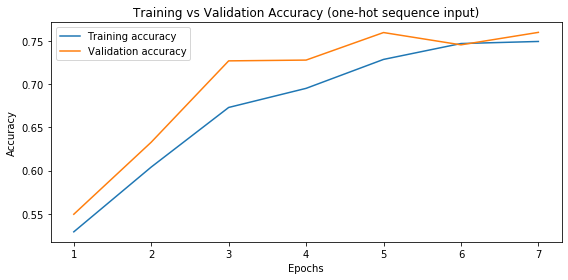

Best epoch by validation accuracy: 7


In [5]:
early = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, mode='max', restore_best_weights=True)

history = model.fit(
    x_tr, y_tr,
    validation_data=(x_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH,
    verbose=1,
    callbacks=[early]
)

acc     = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs  = range(1, len(acc) + 1)

import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy (one‑hot sequence input)')
plt.legend()
plt.tight_layout()
plt.show()

best_epoch = int(np.argmax(val_acc)) + 1
print(f'Best epoch by validation accuracy: {best_epoch}')

## What do `x_train[0]` and `x_train[0,0]` represent now?

- `x_train[0]` is a **sequence** (length 500) of **one‑hot vectors** for the **first training review**. Its shape is `(500, 200)`: each time step corresponds to a token position in the review (after padding/truncation), and each 200‑dimensional vector is a one‑hot indicator over the top‑200 vocabulary.
- `x_train[0, 0]` is the **first time step vector** of that review, i.e., a 200‑dimensional **one‑hot vector** where a single index is `1.0` (the token ID at that position) and all others are `0.0`. If the position was padded, it may be the ID reserved for padding (depending on loader/tokenizer conventions).
